In [70]:
import torch
from tqdm import tqdm
from torchvision import models, transforms

import os
from PIL import Image

In [71]:
# needed input dimensions for the CNN
inputDim = (224,224)
inputDir = "./small_images/"
inputDirCNN = "./resized_small_images/"

os.makedirs(inputDirCNN, exist_ok = True)

In [72]:
import numbers

def custom_padding(image):
    width, height = image.size
    pad = int(abs(height - width) / 2)

    return pad

class NewPad(object):
    def __init__(self, fill=255, padding_mode='constant'):
        assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']

        self.fill = fill
        self.padding_mode = padding_mode
    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be padded.

        Returns:
            PIL Image: Padded image.
        """
        return transforms.functional.pad(img, custom_padding(img), self.fill, self.padding_mode)
    
    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'.\
            format(self.fill, self.padding_mode)

In [73]:
transformationForCNNInput = transforms.Compose([NewPad(), transforms.Resize((224,224))])

In [74]:
for imageName in os.listdir(inputDir):
    I = Image.open(os.path.join(inputDir, imageName))
    try:
        newI = transformationForCNNInput(I)
    except:
        print("Error:", imageName)

    if "exif" in I.info:
        exif = I.info['exif']
        newI.save(os.path.join(inputDirCNN, imageName), exif=exif)
    else:
        newI.save(os.path.join(inputDirCNN, imageName))

In [75]:
class Img2VecResnet18():
    def __init__(self):
        
        self.device = torch.device("cuda")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
        # normalize the resized images as expected by resnet18
        # [0.485, 0.456, 0.406] --> normalized mean value of ImageNet, [0.229, 0.224, 0.225] std of ImageNet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):
        
        cnnModel = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnnModel, layer

In [77]:
class Img2VecResnet18():
    def __init__(self):
        
        self.device = torch.device("cuda")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
        # normalize the resized images as expected by resnet18
        # [0.485, 0.456, 0.406] -> normalized mean value of ImageNet, [0.229, 0.224, 0.225] std of ImageNet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):
        cnnModel = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnnModel, layer

In [107]:
# generate vectors for all the images in the set
img2vec = Img2VecResnet18()

error_imgs = []

allVectors = {}
print("Converting images to feature vectors:")
for image in tqdm(os.listdir("resized_small_images")):
    I = Image.open(os.path.join("resized_small_images", image))
    try:
        vec = img2vec.getVec(I)
        allVectors[image] = vec
    except:
        error_imgs.append(image)
    I.close() 

Converting images to feature vectors:


100%|██████████| 3098/3098 [00:15<00:00, 194.51it/s]


In [108]:
print(error_imgs)

['72313366.png', '72373342.png', '73194799.png', '73473476.png', '74080603.png', 'image.gif', 'nike.jpg', 'Paramount_Global.png']


In [80]:
import pandas as pd
import numpy as np

def getSimilarityMatrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    
    return matrix
        
similarityMatrix = getSimilarityMatrix(allVectors)

In [81]:
from numpy.testing import assert_almost_equal
import pickle

k = 5 # the number of top similar images to be stored

similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))

for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values
    
similarNames.to_pickle("similarNames.pkl")
similarValues.to_pickle("similarValues.pkl")

100%|██████████| 3090/3090 [00:01<00:00, 2827.39it/s]


In [82]:
import matplotlib.pyplot as plt

numCol = 5
numRow = 1

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 12)
    else:
        ax.set_xlabel("Similarity value {1:1.3f}\n{0}".format( image,  value), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])
    
def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        if image in imgs:
            assert_almost_equal(max(vals), 1, decimal = 5)
            imgs.remove(image)
            vals.remove(max(vals))
        return imgs, vals
    else:
        print("'{}' Unknown image".format(image))
        
def plotSimilarImages(image, simiarNames, similarValues):
    simImages, simValues = getSimilarImages(image, similarNames, similarValues)
    fig = plt.figure(figsize=(20, 30))
    
    # now plot the  most simliar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0:
            img = Image.open(os.path.join(inputDir, image))
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else:
            img = Image.open(os.path.join(inputDir, simImages[j-1]))
            ax.append(fig.add_subplot(numRow, numCol, j+1))
            setAxes(ax[-1], simImages[j-1], value = simValues[j-1])
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()
    
    plt.show()

In [83]:
img = Image.open("./test.jpg")

In [84]:
def getSimilarityVector(vectors, query_image):
    v = np.array(list(vectors.values())).T

    img2vec = Img2VecResnet18() 

    query_image_vec = img2vec.getVec(query_image)

    similars = np.inner(v.T, query_image_vec) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(query_image_vec, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(similars, columns = ["query_image"], index = keys)
    
    return matrix

In [85]:
v = np.array(list(allVectors.values())).T

In [86]:
v.shape

(512, 3090)

In [87]:
keys = list(allVectors.keys())

In [93]:
image = "74243094.png"
# image = "74092293.png"
query_image = Image.open(f"./small_images/{image}")

In [94]:
img2vec = Img2VecResnet18() 

query_image_vec = np.array(img2vec.getVec(query_image))

query_image_vec.shape

(512,)

In [95]:
similars = np.inner(v.T, query_image_vec.T) / (np.linalg.norm(v, axis=0) * (np.linalg.norm(query_image_vec, axis=0)).T)
matrix = pd.DataFrame(similars, columns = ["query_image"], index = keys)

In [96]:
topK = matrix.sort_values(by=["query_image"], ascending = False).head(5)

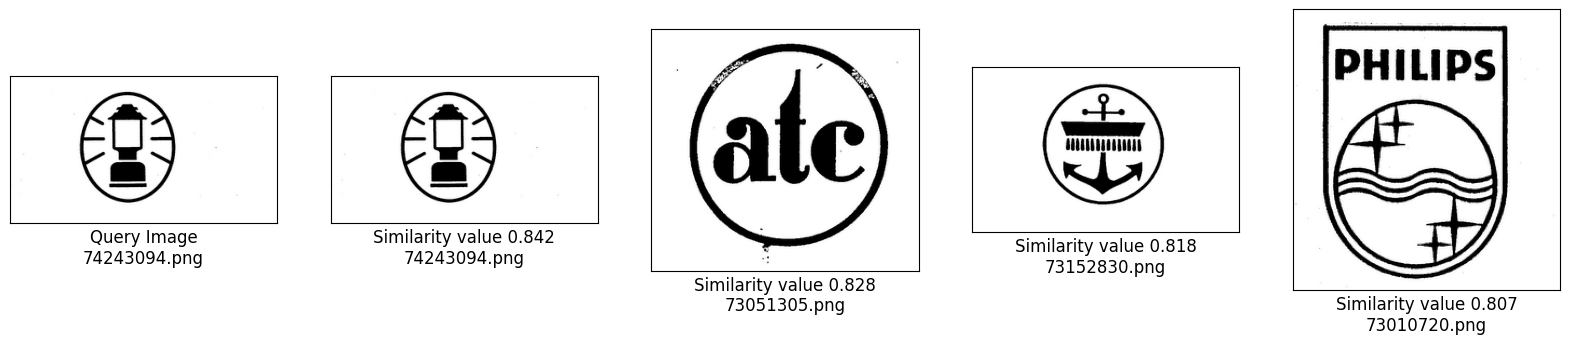

In [97]:
numCol = 5
numRow = 1

fig = plt.figure(figsize=(20, 30))
    
# now plot the  most simliar images
for j in range(0, numCol*numRow):
    ax = []
    if j == 0:
        img = Image.open(os.path.join(inputDir, image))
        ax = fig.add_subplot(numRow, numCol, 1)
        setAxes(ax, image, query = True)
    else:
        img = Image.open(os.path.join(inputDir, topK.iloc[j-1].name))
        ax.append(fig.add_subplot(numRow, numCol, j+1))
        setAxes(ax[-1], topK.iloc[j-1].name, value = topK.iloc[j-1].query_image)
    img = img.convert('RGB')
    plt.imshow(img)
    img.close()

plt.show()

In [98]:
def getAndPlotSimImages(imageNames):
    for i in range(len(imageNames)):
        imageName = imageNames[i]

        query_image = Image.open(f"./small_images/{imageName}")
        
        img2vec = Img2VecResnet18() 

        query_image_vec = np.array(img2vec.getVec(query_image))

        similars = np.inner(v.T, query_image_vec.T) / (np.linalg.norm(v, axis=0) * (np.linalg.norm(query_image_vec, axis=0)).T)
        matrix = pd.DataFrame(similars, columns = ["query_image"], index = keys)

        topK = matrix.sort_values(by=["query_image"], ascending = False).head(5)

        numCol = 5
        numRow = 1

        fig = plt.figure(figsize=(20, 30))
            
        # now plot the  most simliar images
        for j in range(0, numCol*numRow):
            ax = []
            if j == 0:
                img = Image.open(os.path.join(inputDir, imageName))
                ax = fig.add_subplot(numRow, numCol, 1)
                setAxes(ax, imageName, query = True)
            else:
                img = Image.open(os.path.join(inputDir, topK.iloc[j-1].name))
                ax.append(fig.add_subplot(numRow, numCol, j+1))
                setAxes(ax[-1], topK.iloc[j-1].name, value = topK.iloc[j-1].query_image)
            img = img.convert('RGB')
            plt.imshow(img)
            img.close()

        plt.show()

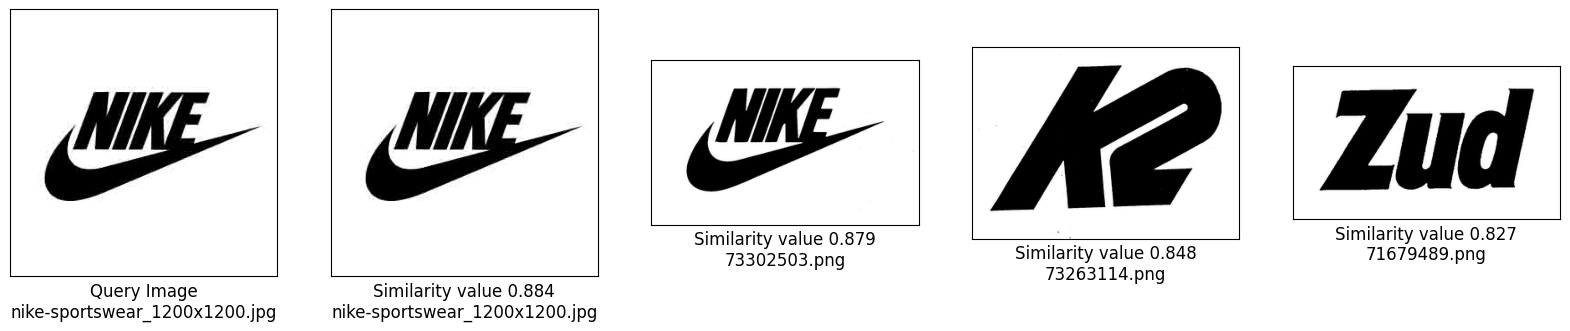

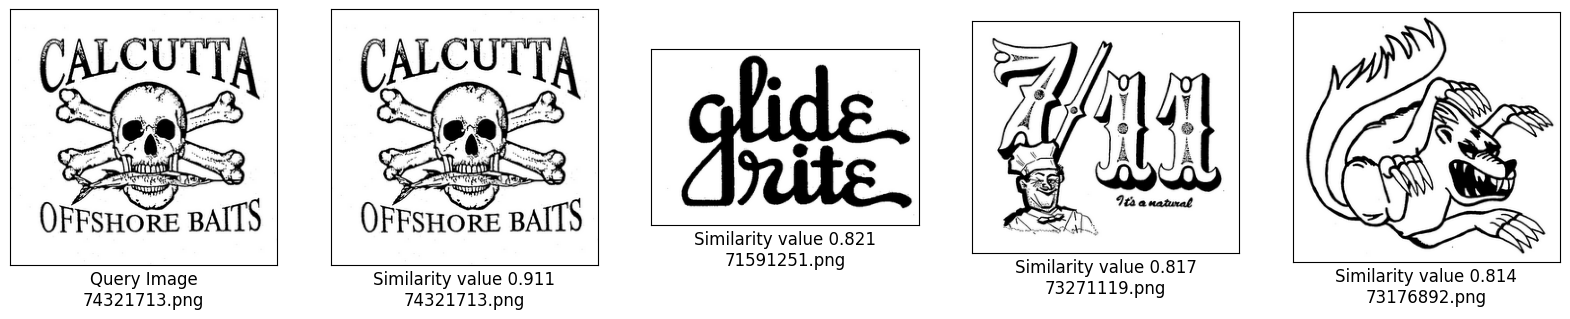

In [106]:
getAndPlotSimImages(["nike-sportswear_1200x1200.jpg", "74321713.png"])